## Neural Network Implementation

Importing required packages

In [510]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report

Importing Dataset and exploring the labels.

In [456]:
df = pd.read_csv('NTSB_baseline_for_model_unbalanced.csv', low_memory=False)
pd.set_option('display.max_rows', 100)
df.dtypes

Unnamed: 0                 int64
flight_plan_activated      int64
acft_make                  int64
acft_model                 int64
cert_max_gr_wt             int64
num_eng                    int64
type_last_insp             int64
date_last_insp             int64
afm_hrs_last_insp        float64
afm_hrs                    int64
type_fly                   int64
dprt_apt_id                int64
dprt_city                  int64
dprt_state                 int64
dprt_time                  int64
dest_same_local            int64
dest_apt_id                int64
dest_city                  int64
dest_state                 int64
afm_hrs_since              int64
rwy_num                    int64
rwy_len                  float64
rwy_width                float64
ifr_equipped_cert           bool
eng_no                   float64
eng_type                   int64
eng_mfgr                   int64
eng_time_total           float64
eng_time_last_insp       float64
ev_date                    int64
ev_dow    

In [457]:
#Dropping columns. wx_obs_fac_id used for joining with weather data, needed for analysis? last two for class, not needed for model?
df = df.drop(['ev_date', 'ev_city', 'ev_state', 'date_last_insp', 'dest_same_local', 'dest_apt_id', 'dest_city',  'dest_state', 'ev_time', 
             'flight_plan_activated', 'eng_time_total', 'eng_time_last_insp', 'latitude', 
              'longitude','wx_dens_alt','crew_no', 'crew_sex', 'crew_age','afm_hrs_since'], axis=1)

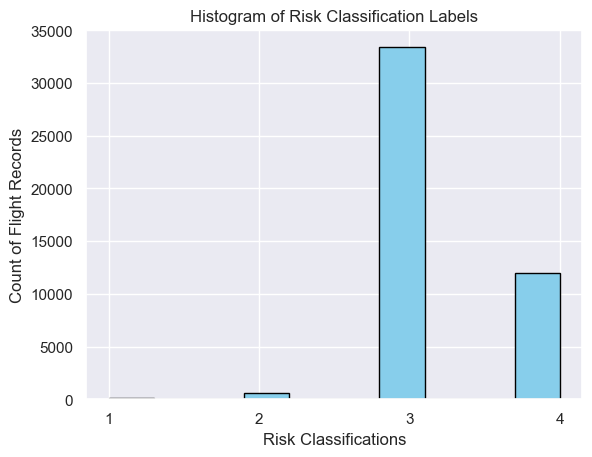

In [458]:
# Plotting a histogram of the risk classificiation labels
plt.hist(df['target'], color='skyblue', edgecolor='black')
plt.xlabel('Risk Classifications')
plt.ylabel('Count of Flight Records')
plt.title('Histogram of Risk Classification Labels')
plt.xticks(range(int(df['target'].min()), int(df['target'].max())+1))
plt.show()

### Balancing the Dataset

In [429]:
df['target'].value_counts()

3    33403
4    11968
2      589
1       92
Name: target, dtype: int64

In [433]:
# Split the data into features (X) and target variable (y)
X = df.drop('target', axis=1)
y = df['target']

# Calculate the class distribution
class_counts = y.value_counts().to_dict()

# Define the desired target counts for each class
target_counts = {
    1: class_counts.get(1, 0) + 10000,  # Oversample class 1 (increase by 10000)
    2: class_counts.get(2, 0) + 10000,  # Oversample class 2 (increase by 10000)
    3: class_counts.get(3, 0) // 3,     # Undersample class 3 (half of the original count)
    4: class_counts.get(4, 0) // 1      # Undersample class 4 (half of the original count)
}

# Creating the pipeline to implement the sampling strategy
pipeline = make_pipeline(
    RandomUnderSampler(sampling_strategy={3: target_counts[3], 4: target_counts[4]}),
    RandomOverSampler(sampling_strategy={1: target_counts[1], 2: target_counts[2]})
)

# Perform the combined sampling
X_resampled, y_resampled = pipeline.fit_resample(X, y)


# Create a new DataFrame with the resampled data
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['target'] = y_resampled

# Verify the class distribution after sampling
resampled_df['target'].value_counts()

4    11968
3    11134
2    10589
1    10092
Name: target, dtype: int64

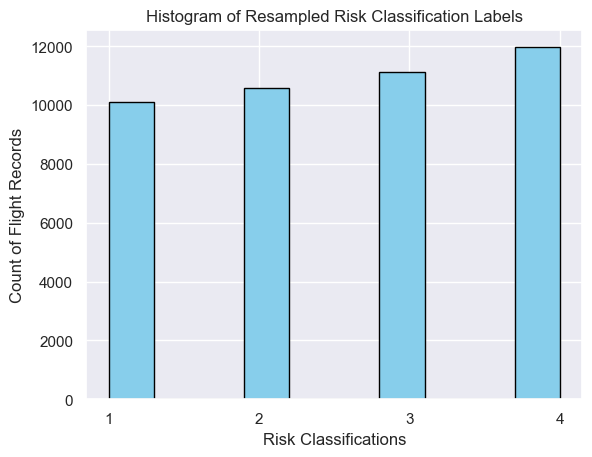

In [509]:
# Histogram of the adjusted dataset
plt.hist(resampled_df['target'], color='skyblue', edgecolor='black')
plt.xlabel('Risk Classifications')
plt.ylabel('Count of Flight Records')
plt.title('Histogram of Resampled Risk Classification Labels')
plt.xticks(range(int(resampled_df['target'].min()), int(resampled_df['target'].max())+1))
plt.show()

# Initiating NN - using unbalanced dataset

In [474]:

# Split the data into features (X) and target variable (y)
X = df.drop('target', axis=1)
y = df['target']

# Perform multiple imputation
imputer = IterativeImputer()
X_imputed = imputer.fit_transform(X)

# Create a new DataFrame with imputed values
columns = X.columns
df_imputed = pd.DataFrame(X_imputed, columns=columns)

# Add the target column back to the imputed DataFrame
df_imputed['target'] = y

# Verify if the imputation is successful
print(df_imputed.isnull().sum())

Unnamed: 0           0
acft_make            0
acft_model           0
cert_max_gr_wt       0
num_eng              0
type_last_insp       0
afm_hrs_last_insp    0
afm_hrs              0
type_fly             0
dprt_apt_id          0
dprt_city            0
dprt_state           0
dprt_time            0
rwy_num              0
rwy_len              0
rwy_width            0
ifr_equipped_cert    0
eng_no               0
eng_type             0
eng_mfgr             0
ev_dow               0
ev_month             0
apt_name             0
apt_elev             0
wx_obs_time          0
light_cond           0
sky_cond_nonceil     0
sky_nonceil_ht       0
sky_ceil_ht          0
sky_cond_ceil        0
vis_rvr              0
vis_sm               0
wx_temp              0
wx_dew_pt            0
wind_dir_deg         0
wind_dir_ind         0
wind_vel_kts         0
gust_kts             0
altimeter            0
wx_int_precip        0
wx_cond_basic        0
ACTU                 0
ALL                  0
MAKE       

In [498]:
# Split the data into features (X) and target variable (y)
X = df_imputed.drop('target', axis=1)
y = df_imputed['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert the target variables to categorical
num_classes = df_imputed['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)

# Define your model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)

y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)
print("Test accuracy:", accuracy)

Epoch 1/10
876/876 [==============================] - 1s 1ms/step - loss: 245.1841 - accuracy: 0.3766 - val_loss: 42.8479 - val_accuracy: 0.4659
Epoch 2/10
876/876 [==============================] - 1s 1ms/step - loss: 33.7162 - accuracy: 0.4467 - val_loss: 26.2982 - val_accuracy: 0.3735
Epoch 3/10
876/876 [==============================] - 1s 1ms/step - loss: 22.1085 - accuracy: 0.4677 - val_loss: 29.5478 - val_accuracy: 0.3867
Epoch 4/10
876/876 [==============================] - 1s 1ms/step - loss: 18.2136 - accuracy: 0.4802 - val_loss: 17.1295 - val_accuracy: 0.4961
Epoch 5/10
876/876 [==============================] - 1s 1ms/step - loss: 14.6024 - accuracy: 0.4922 - val_loss: 9.5369 - val_accuracy: 0.4960
Epoch 6/10
876/876 [==============================] - 1s 1ms/step - loss: 11.3047 - accuracy: 0.5053 - val_loss: 12.2692 - val_accuracy: 0.4789
Epoch 7/10
876/876 [==============================] - 1s 1ms/step - loss: 10.6297 - accuracy: 0.5079 - val_loss: 6.5995 - val_accuracy: 

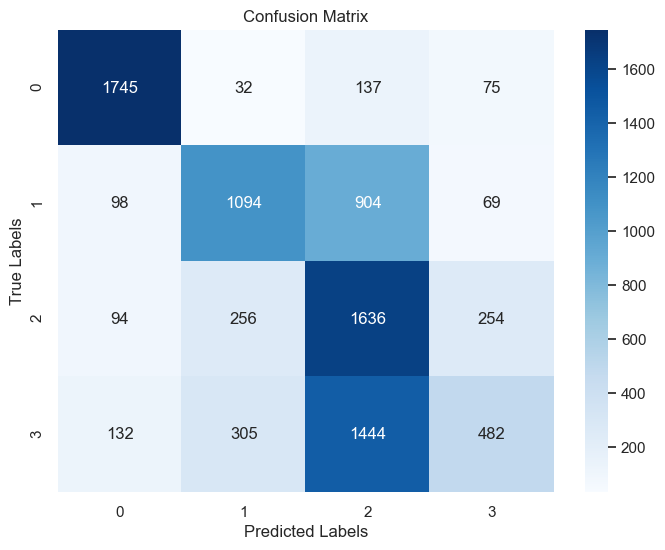

In [500]:


# Calculate the confusion matrix
cm1 = confusion_matrix(y_test_labels + 1, y_pred_labels + 1)  # Add 1 to adjust class labels

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [501]:
from sklearn.metrics import classification_report

# Generate the classification report
classification_report1 = classification_report(y_test_labels, y_pred_labels)

print(classification_report1)

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1989
           1       0.73      0.20      0.31      2165
           2       0.44      0.15      0.23      2240
           3       0.33      0.78      0.47      2363

    accuracy                           0.48      8757
   macro avg       0.59      0.48      0.46      8757
weighted avg       0.57      0.48      0.45      8757



In [489]:
print(model.history.history.keys())

dict_keys([])


## NN with data imputed by class first

In [502]:
# Split the data into features (X) and target variable (y)
X = df.drop('target', axis=1)
y = df['target']

# Initialize an empty DataFrame for imputed data
df_imputed = pd.DataFrame()

# Iterate over unique target classes
for class_value in y.unique():
    # Split data for the current class
    X_class = X[y == class_value]
    
    # Perform imputation on the current class
    imputer = IterativeImputer()
    X_class_imputed = imputer.fit_transform(X_class)
    
    # Concatenate the imputed data for the current class
    df_imputed = pd.concat([df_imputed, pd.DataFrame(X_class_imputed, columns=X.columns)])
    
# Add the target column back to the imputed DataFrame
df_imputed['target'] = y

# Verify if the imputation is successful
print(df_imputed.isnull().sum())

Unnamed: 0           0
acft_make            0
acft_model           0
cert_max_gr_wt       0
num_eng              0
type_last_insp       0
afm_hrs_last_insp    0
afm_hrs              0
type_fly             0
dprt_apt_id          0
dprt_city            0
dprt_state           0
dprt_time            0
rwy_num              0
rwy_len              0
rwy_width            0
ifr_equipped_cert    0
eng_no               0
eng_type             0
eng_mfgr             0
ev_dow               0
ev_month             0
apt_name             0
apt_elev             0
wx_obs_time          0
light_cond           0
sky_cond_nonceil     0
sky_nonceil_ht       0
sky_ceil_ht          0
sky_cond_ceil        0
vis_rvr              0
vis_sm               0
wx_temp              0
wx_dew_pt            0
wind_dir_deg         0
wind_dir_ind         0
wind_vel_kts         0
gust_kts             0
altimeter            0
wx_int_precip        0
wx_cond_basic        0
ACTU                 0
ALL                  0
MAKE       

In [503]:
# Split the data into features (X) and target variable (y)
X = df_imputed.drop('target', axis=1)
y = df_imputed['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert the target variables to categorical
num_classes = df_imputed['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)

# Define your model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)

y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)
print("Test accuracy:", accuracy)

Epoch 1/10
921/921 [==============================] - 1s 1ms/step - loss: 55.0055 - accuracy: 0.5811 - val_loss: 13.4198 - val_accuracy: 0.5374
Epoch 2/10
921/921 [==============================] - 1s 1ms/step - loss: 12.6276 - accuracy: 0.5767 - val_loss: 27.2793 - val_accuracy: 0.6554
Epoch 3/10
921/921 [==============================] - 1s 1ms/step - loss: 10.2657 - accuracy: 0.5803 - val_loss: 4.1032 - val_accuracy: 0.5392
Epoch 4/10
921/921 [==============================] - 1s 1ms/step - loss: 6.2836 - accuracy: 0.5795 - val_loss: 4.2532 - val_accuracy: 0.6943
Epoch 5/10
921/921 [==============================] - 1s 1ms/step - loss: 5.0221 - accuracy: 0.5796 - val_loss: 2.6080 - val_accuracy: 0.6314
Epoch 6/10
921/921 [==============================] - 1s 1ms/step - loss: 4.0341 - accuracy: 0.5836 - val_loss: 2.6773 - val_accuracy: 0.6628
Epoch 7/10
921/921 [==============================] - 1s 1ms/step - loss: 3.2506 - accuracy: 0.5912 - val_loss: 1.5227 - val_accuracy: 0.6443
E

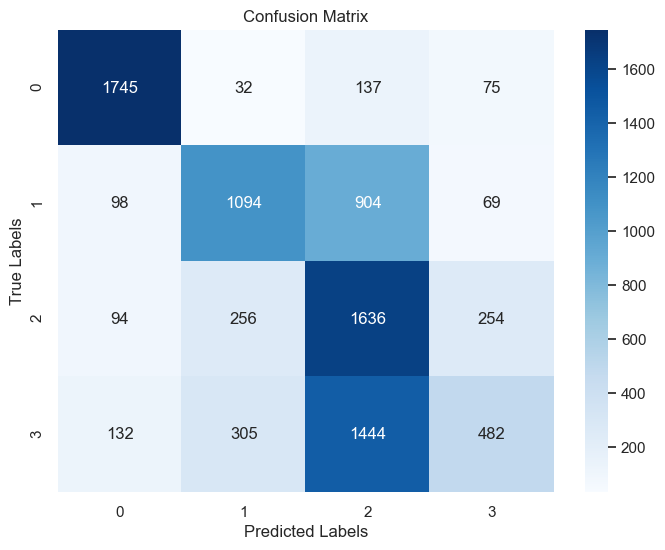

In [504]:
# Calculate the confusion matrix
cm1 = confusion_matrix(y_test_labels + 1, y_pred_labels + 1)  # Add 1 to adjust class labels

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [508]:


# Generate the classification report
classification_report2 = classification_report(y_test_labels, y_pred_labels)

print(classification_report2)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.00      0.00      0.00       474
           2       0.93      1.00      0.97      8183
           3       0.00      0.00      0.00        34

    accuracy                           0.93      8757
   macro avg       0.23      0.25      0.24      8757
weighted avg       0.87      0.93      0.90      8757



## NN Using Resampled Data

In [505]:


# Split the data into features (X) and target variable (y)
X = resampled_df.drop('target', axis=1)
y = resampled_df['target']

# Initialize an empty DataFrame for imputed data
df_imputed = pd.DataFrame()

# Iterate over unique target classes
for class_value in y.unique():
    # Split data for the current class
    X_class = X[y == class_value]
    
    # Perform imputation on the current class
    imputer = IterativeImputer()
    X_class_imputed = imputer.fit_transform(X_class)
    
    # Concatenate the imputed data for the current class
    df_imputed = pd.concat([df_imputed, pd.DataFrame(X_class_imputed, columns=X.columns)])
    
# Add the target column back to the imputed DataFrame
df_imputed['target'] = y

# Verify if the imputation is successful
print(df_imputed.isnull().sum())

Unnamed: 0           0
acft_make            0
acft_model           0
cert_max_gr_wt       0
num_eng              0
type_last_insp       0
afm_hrs_last_insp    0
afm_hrs              0
type_fly             0
dprt_apt_id          0
dprt_city            0
dprt_state           0
dprt_time            0
rwy_num              0
rwy_len              0
rwy_width            0
ifr_equipped_cert    0
eng_no               0
eng_type             0
eng_mfgr             0
ev_date              0
ev_dow               0
ev_city              0
ev_state             0
ev_month             0
apt_name             0
apt_elev             0
wx_obs_time          0
light_cond           0
sky_cond_nonceil     0
sky_nonceil_ht       0
sky_ceil_ht          0
sky_cond_ceil        0
vis_rvr              0
vis_sm               0
wx_temp              0
wx_dew_pt            0
wind_dir_deg         0
wind_dir_ind         0
wind_vel_kts         0
gust_kts             0
altimeter            0
wx_int_precip        0
wx_cond_bas

In [506]:
# Split the data into features (X) and target variable (y)
X = df_imputed.drop('target', axis=1)
y = df_imputed['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert the target variables to categorical
num_classes = df_imputed['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)


# Define your model architecture
model = keras.Sequential([
     keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
     keras.layers.Dense(32, activation='relu'),
     keras.layers.Dense(num_classes, activation='softmax')
 ])

# Compile your model
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])



# Train the model
model.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)

y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)
print("Test accuracy:", accuracy)

Epoch 1/10
876/876 [==============================] - 2s 1ms/step - loss: 482786737651712.0000 - accuracy: 0.8720 - val_loss: 1043639673290752.0000 - val_accuracy: 0.8911
Epoch 2/10
876/876 [==============================] - 1s 1ms/step - loss: 583366952878080.0000 - accuracy: 0.8765 - val_loss: 336629000568832.0000 - val_accuracy: 0.9142
Epoch 3/10
876/876 [==============================] - 1s 1ms/step - loss: 390157144424448.0000 - accuracy: 0.8767 - val_loss: 169026173009920.0000 - val_accuracy: 0.8420
Epoch 4/10
876/876 [==============================] - 1s 1ms/step - loss: 104038183993344.0000 - accuracy: 0.8732 - val_loss: 74194402410496.0000 - val_accuracy: 0.9308
Epoch 5/10
876/876 [==============================] - 1s 1ms/step - loss: 246671044771840.0000 - accuracy: 0.8756 - val_loss: 17654207217664.0000 - val_accuracy: 0.8848
Epoch 6/10
876/876 [==============================] - 1s 1ms/step - loss: 198822961610752.0000 - accuracy: 0.8737 - val_loss: 75843174924288.0000 - val

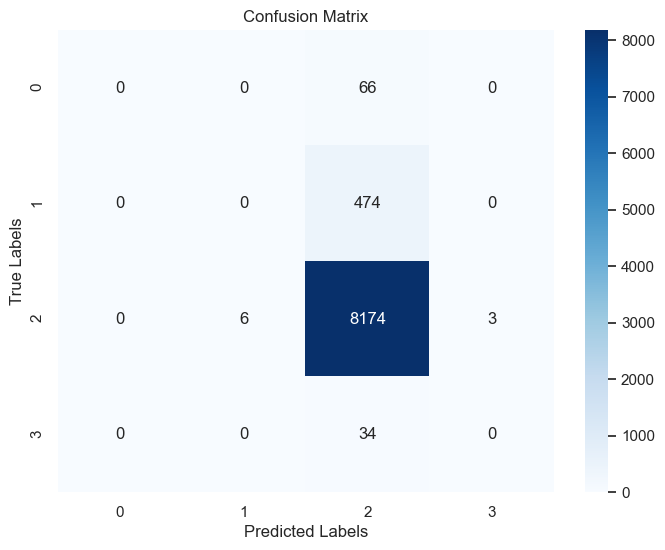

In [507]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)  # Add 1 to adjust class labels

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [123]:
df.columns

Index(['Unnamed: 0', 'aircraft_ev_id', 'far_part', 'flight_plan_activated',
       'damage', 'acft_make', 'acft_model', 'cert_max_gr_wt', 'num_eng',
       'type_last_insp', 'date_last_insp', 'afm_hrs_last_insp', 'afm_hrs',
       'type_fly', 'dprt_apt_id', 'dprt_city', 'dprt_state', 'dprt_time',
       'dest_same_local', 'dest_apt_id', 'dest_city', 'dest_state',
       'phase_flt_spec', 'afm_hrs_since', 'rwy_num', 'rwy_len', 'rwy_width',
       'ifr_equipped_cert', 'eng_no', 'eng_type', 'eng_mfgr', 'hp_or_lbs',
       'carb_fuel_injection', 'eng_time_total', 'eng_time_last_insp',
       'ntsb_no', 'ev_type', 'ev_date', 'ev_dow', 'ev_time', 'ev_city',
       'ev_state', 'ev_year', 'ev_month', 'latitude', 'longitude', 'apt_name',
       'apt_dist', 'apt_dir', 'apt_elev', 'wx_src_iic', 'wx_obs_time',
       'wx_obs_dir', 'wx_obs_fac_id', 'wx_obs_elev', 'wx_obs_dist',
       'light_cond', 'sky_cond_nonceil', 'sky_nonceil_ht', 'sky_ceil_ht',
       'sky_cond_ceil', 'vis_rvr', 'vis_sm', 'wx

In [87]:
categorical_columns = ['flight_plan_activated', 'damage', 'acft_make', 'acft_model', 'cert_max_gr_wt', 'type_last_insp', 'type_fly', 'dprt_apt_id', 'dprt_city', 'dprt_state', 
                       'phase_flt_spec', 'afm_hrs_since', 'rwy_num', 'ifr_equipped_cert', 'eng_type', 'eng_mfgr', 'hp_or_lbs','carb_fuel_injection', 'ev_dow','ev_time','rwy_len', 'rwy_width', 'ev_state', 'ev_year', 'ev_month', 'latitude', 
                       'longitude', 'apt_name','wx_src_iic','wx_obs_fac_id','light_cond', 'sky_cond_nonceil','sky_cond_ceil','wind_dir_ind','wind_vel_ind',
                       'gust_ind', 'wx_int_precip','wx_cond_basic','pilot_flying']
                       
                       

In [147]:
pd.set_option('display.max_rows', 100)
df.dtypes

Unnamed: 0                        int64
aircraft_ev_id                   object
far_part                          int64
flight_plan_activated            object
damage                           object
acft_make                        object
acft_model                       object
cert_max_gr_wt                   object
num_eng                           int64
type_last_insp                   object
date_last_insp                   object
afm_hrs_last_insp               float64
afm_hrs                           int64
type_fly                         object
dprt_apt_id                      object
dprt_city                        object
dprt_state                       object
dprt_time                        object
dest_same_local                  object
dest_apt_id                      object
dest_city                        object
dest_state                       object
phase_flt_spec                  float64
afm_hrs_since                    object
rwy_num                          object


In [88]:
numerical_columns = ['afm_hrs_last_insp', 'afm_hrs', 'eng_no', 'eng_time_total', 'eng_time_last_insp', 'apt_dist', 'apt_dir', 
                     'wx_obs_time', 'wx_obs_dir', 'wx_obs_elev', 'wx_obs_dist', 'sky_nonceil_ht', 'sky_ceil_ht', 'vis_rvr', 'vis_sm', 'wx_temp', 'wx_dew_pt',
                   'wind_dir_deg','wind_vel_kts','gust_kts','altimeter', 'wx_dens_alt']
                     

In [89]:
outputs = ['target']

In [255]:
df.head()


,Unnamed: 0,flight_plan_activated,acft_make,acft_model,cert_max_gr_wt,num_eng,type_last_insp,date_last_insp,afm_hrs_last_insp,afm_hrs,...,crew_sex,target,ACTU,ALL,MAKE,MENG,NGHT,ROTO,SENG,SIMU
0,0,-1,366,18,1,2,1,1013,3.0,7687,...,-1,4,NaN,4100.0,NaN,NaN,NaN,4100.0,NaN,NaN
1,1,-1,37,18,2,2,2,1638,13.0,5515,...,-1,4,NaN,798.0,298.0,NaN,NaN,NaN,NaN,NaN
2,2,-1,1580,18,2,1,2,9223,10.0,741,...,-1,3,NaN,500.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,-1,366,18,2,2,2,8197,106.0,5369,...,-1,4,NaN,2801.0,2.0,2.000000,1.0,NaN,NaN,NaN
4,4,-1,366,18,2,2,2,2865,141.0,3678,...,-1,4,31.0,1878.0,10.0,37.333333,23.0,NaN,NaN,NaN


In [269]:
df_imputed.isna().sum() 

Unnamed: 0               0
flight_plan_activated    0
acft_make                0
acft_model               0
cert_max_gr_wt           0
num_eng                  0
type_last_insp           0
date_last_insp           0
afm_hrs_last_insp        0
afm_hrs                  0
type_fly                 0
dprt_apt_id              0
dprt_city                0
dprt_state               0
dprt_time                0
dest_same_local          0
dest_apt_id              0
dest_city                0
dest_state               0
afm_hrs_since            0
rwy_num                  0
rwy_len                  0
rwy_width                0
ifr_equipped_cert        0
eng_no                   0
eng_type                 0
eng_mfgr                 0
eng_time_total           0
eng_time_last_insp       0
ev_date                  0
ev_dow                   0
ev_time                  0
ev_city                  0
ev_state                 0
ev_month                 0
latitude                 0
longitude                0
a

In [254]:
#Dropping columns. wx_obs_fac_id used for joining with weather data, needed for analysis? last two for class, not needed for model?
df = df.drop(['far_part', 'date_last_insp', 'dest_same_local', 'dest_apt_id', 'dest_city',  'dest_state',  
              'phase_flt_spec', 'ev_time',  'apt_dist',  'apt_dir',  'apt_name', 
              'wx_obs_dir', 'wx_obs_fac_id', 'wx_obs_elev','wx_obs_dist', 'ev_highest_injury', 'inj_tot_t', 
              'crew_inj_level', 'damage', 'flight_plan_activated', 'eng_time_total', 'eng_time_last_insp',
               'latitude', 'longitude','wx_dens_alt','crew_no','crew_category', 'crew_sex', 'med_certf',
               'crew_age','afm_hrs_since'], axis=1)



KeyError: "['far_part', 'phase_flt_spec', 'apt_dist', 'apt_dir', 'wx_obs_dir', 'wx_obs_fac_id', 'wx_obs_elev', 'wx_obs_dist', 'ev_highest_injury', 'inj_tot_t', 'crew_inj_level', 'damage', 'crew_category', 'med_certf'] not found in axis"

In [243]:
df.dtypes

Unnamed: 0                      int64
aircraft_ev_id                 object
acft_make                      object
acft_model                     object
cert_max_gr_wt                 object
num_eng                         int64
type_last_insp                 object
afm_hrs_last_insp             float64
afm_hrs                         int64
type_fly                       object
dprt_apt_id                    object
dprt_city                      object
dprt_state                     object
dprt_time                      object
rwy_num                        object
rwy_len                       float64
rwy_width                     float64
ifr_equipped_cert                bool
eng_no                        float64
eng_type                       object
eng_mfgr                       object
hp_or_lbs                      object
carb_fuel_injection            object
ntsb_no                        object
ev_type                        object
ev_date                datetime64[ns]
ev_dow      

In [256]:
df.shape

(46052, 69)

In [262]:
df.isna().sum()                      

Unnamed: 0                   0
flight_plan_activated        0
acft_make                    0
acft_model                   0
cert_max_gr_wt               0
num_eng                      0
type_last_insp               0
date_last_insp               0
afm_hrs_last_insp        10528
afm_hrs                      0
type_fly                     0
dprt_apt_id                  0
dprt_city                    0
dprt_state                   0
dprt_time                    0
dest_same_local              0
dest_apt_id                  0
dest_city                    0
dest_state                   0
afm_hrs_since                0
rwy_num                      0
rwy_len                  20711
rwy_width                21971
ifr_equipped_cert            0
eng_no                     175
eng_type                     0
eng_mfgr                     0
eng_time_total           43804
eng_time_last_insp       44205
ev_date                      0
ev_dow                       0
ev_time                     16
ev_city 

In [263]:
# Correcting floats to integer data types, and dropping any rows with NA in these colums

df2_formatted = df.dropna(axis='columns')



In [264]:
df2_formatted.head()

,Unnamed: 0,flight_plan_activated,acft_make,acft_model,cert_max_gr_wt,num_eng,type_last_insp,date_last_insp,afm_hrs,type_fly,...,longitude,apt_name,light_cond,sky_cond_nonceil,sky_cond_ceil,wind_dir_ind,wx_int_precip,wx_cond_basic,crew_sex,target
0,0,-1,366,18,1,2,1,1013,7687,6,...,-1,4478,1,-1,0,0,4,0,-1,4
1,1,-1,37,18,2,2,2,1638,5515,13,...,-1,6697,1,1,1,0,-1,1,-1,4
2,2,-1,1580,18,2,1,2,9223,741,13,...,-1,1260,1,3,1,2,0,1,-1,3
3,3,-1,366,18,2,2,2,8197,5369,5,...,-1,10223,4,-1,3,0,2,0,-1,4
4,4,-1,366,18,2,2,2,2865,3678,5,...,-1,3938,4,-1,2,0,2,0,-1,4


In [226]:

df2_formatted = df2_formatted.astype({"afm_hrs_last_insp":'int64', "rwy_len":'category', 
               "rwy_width":'category', "eng_no":'int64', "eng_time_total":'int64', 
                "eng_time_last_insp":'int64', "apt_elev":'int64',  "wx_obs_time":'int64',
                "sky_nonceil_ht":'int64', "sky_ceil_ht":'int64', "vis_rvr":'int64', 
                "vis_sm":'int64', "wx_temp":'int64', "wx_dew_pt":'int64', "wind_dir_deg":'int64', 
                "wind_vel_kts":'int64', "gust_kts":'int64', "altimeter":'int64', "wx_dens_alt":'int64', 
                "crew_no":'int64', "crew_age":'int64', "secondary_eng_mfgr":'category'})

AttributeError: 'NoneType' object has no attribute 'astype'

In [216]:
df2_formatted.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()


,aircraft_ev_id,latitude,longitude


In [162]:
df2_formatted = df.astype({"damage":'category', "acft_make":'category',
                                      "acft_model":'category', "cert_max_gr_wt":'category',  "type_last_insp":'category',  
                                      "type_fly":'category', "dprt_apt_id":'category',  "dprt_city":'category',  
                                      "dprt_state":'category',  "dprt_time":'category',  "afm_hrs_since":'category',  
                                      "rwy_num":'category',  "ifr_equipped_cert":'category',  "eng_type":'category', 
                                      "afm_hrs":'category',  "dprt_time":'category',  "eng_mfgr":'category',
                                      "hp_or_lbs":'category',  "carb_fuel_injection":'category',  "eng_time_last_insp":'category',  
                                      "eng_time_total":'category', "ev_type":'category', "ev_dow":'category',
                                      "ev_city":'category', "ev_state":'category', "ev_month":'category', "rwy_len":'category', 
                                      "rwy_width":'category', "secondary_eng_mfgr":'category',"wx_src_iic":'category', "light_cond":'category',
                                      "sky_cond_nonceil":'category', "sky_cond_ceil":'category', "wind_dir_ind":'category', "wind_vel_ind": 'category', 
                                      "gust_ind":'category', "wx_int_precip":'category', "wx_cond_basic":'category', "crew_category":'category', "crew_sex":'category',
                                       "med_certf":'category', "pilot_flying":'category', "secondary_eng_mfgr":'category'})
                                 

KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'eng_time_last_insp' not found in columns."

In [121]:
df2_formatted

,Unnamed: 0,aircraft_ev_id,far_part,flight_plan_activated,damage,acft_make,acft_model,cert_max_gr_wt,num_eng,type_last_insp,...,wx_cond_basic,crew_no,crew_category,crew_age,crew_sex,med_certf,pilot_flying,crew_inj_level,secondary_eng_mfgr,target


In [ ]:
    
                                      
                                      

                                
df2_formatted['flight_plan_activated'].fillna('Unknown', inplace=True)
df2_formatted['afm_hrs_since'].fillna('Unknown', inplace=True)                                   
df2_formatted['hp_or_lbs'].fillna('Unknown', inplace=True)
df2_formatted['carb_fuel_injection'].fillna('Unknown', inplace=True)
df2_formatted['damage'].fillna('Unknown', inplace=True)
df2_formatted['acft_make'].fillna('Unknown', inplace=True)
df2_formatted['acft_model'].fillna('Unknown', inplace=True)                                      
df2_formatted['cert_max_gr_wt'].fillna('Unknown', inplace=True)
df2_formatted['type_last_insp'].fillna('Unknown', inplace=True)                                      
df2_formatted['type_fly'].fillna('Unknown', inplace=True)                                      
df2_formatted['dprt_apt_id'].fillna('Unknown', inplace=True)                                      
df2_formatted['dprt_city'].fillna('Unknown', inplace=True)                                      
df2_formatted['dprt_state'].fillna('Unknown', inplace=True)                                      
df2_formatted['dprt_time'].fillna('Unknown', inplace=True)                                      
df2_formatted['rwy_num'].fillna('Unknown', inplace=True)                                      
df2_formatted['ifr_equipped_cert'].fillna('Unknown', inplace=True)                                      
df2_formatted['eng_type'].fillna('Unknown', inplace=True)
df2_formatted['afm_hrs'].fillna('Unknown', inplace=True)                                      
df2_formatted['eng_mfgr'].fillna('Unknown', inplace=True) 
df2_formatted['eng_time_last_insp'].fillna('Unknown', inplace=True)                                       
df2_formatted['eng_time_total'].fillna('Unknown', inplace=True)                                       
df2_formatted['ev_type'].fillna('Unknown', inplace=True)                                       
df2_formatted['ev_dow'].fillna('Unknown', inplace=True)                                       
df2_formatted['ev_city'].fillna('Unknown', inplace=True)                                           
df2_formatted['ev_state'].fillna('Unknown', inplace=True)      
df2_formatted['ev_month'].fillna('Unknown', inplace=True)
df2_formatted['rwy_len'].fillna('Unknown', inplace=True)
df2_formatted['rwy_width'].fillna('Unknown', inplace=True)
df2_formatted['secondary_eng_mfgr'].fillna('Unknown', inplace=True)
df2_formatted['crew_no'].fillna('Unknown', inplace=True)                                    
                                                                           

# Clustering Lat/Long per https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1

df2_formatted = df2_formatted.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
# Variable with the Longitude and Latitude
X=df2_formatted.loc[:,['aircraft_ev_id','latitude','longitude']]
X.head(10)    

                                      
df2_formatted['date_last_insp'] = df2_formatted['date_last_insp'].to_datetime()                                     
#Bin: afm_hrs, afm_hrs_last_insp, dprt_time ['1201-1800', '1801-2400', '0001-0600', '0601-1200', nan],  "rwy_len":'category'
#wx_obs_time, sky_nonceil_ht, sky_ceil_ht, vis_rvr (runway visualisation range), vis_sm (visability in statute miles), wx_temp, wx_dew_pt, wind_dir_deg  
#gust_kts, altimeter, wx_dens_alt, crew_age                                    
                                      

df2_formatted = df2_formatted.astype({"afm_hrs_last_insp":'int64', "phase_flt_spec":'int64', "eng_no":'int64', "eng_time_total":'int64', "eng_time_last_insp":'int64', "apt_elev":'int64', "wx_obs_time":'int64', "wx_obs_dir":'int64', "wx_obs_elev":'int64', "wx_obs_dist":'int64', "sky_nonceil_ht":'int64', "sky_ceil_ht":'int64', "vis_rvr":'int64', "vis_sm":'int64', "wx_temp":'int64', "wx_dew_pt":'int64', "wind_dir_deg":'int64', "wind_vel_kts":'int64', "gust_kts":'int64', "altimeter":'int64', "wx_dens_alt":'int64', "inj_tot_t":'int64', "crew_no":'int64', "crew_age":'int64'})
df2_formatted=df.dropna(subset=['afm_hrs_last_insp','phase_flt_spec', 'eng_no', 'eng_time_total', 'eng_time_last_insp', 'apt_elev', 'wx_obs_time', 'wx_obs_dir', 'wx_obs_elev', 'wx_obs_dist', 'sky_nonceil_ht', 'sky_ceil_ht', 'vis_rvr', 'vis_sm', 'wx_temp', 'wx_dew_pt', 'wind_dir_deg', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_dens_alt', 'inj_tot_t', 'crew_no', 'crew_age'])
                                        
                                      
                            

In [101]:
print(df.latitude)

28888        NaN
38654    365520n
31333        NaN
31334        NaN
31335        NaN
          ...   
40212    321926n
40207    384327n
40211    405957n
40205    332754n
40208    282825n
Name: latitude, Length: 49108, dtype: object


In [165]:
nan_count = df['latitude'].isna().sum()
print(nan_count)

df['phase_flt_spec'].describe(include='all') 

33088


KeyError: 'phase_flt_spec'

In [192]:
df['afm_hrs_last_insp'].unique()

array([50. ,  nan,  0. , ..., 33.1, 47.4, 28.2])

In [109]:
# Declaring a value that we need to find
val = '0nan'

# Finding our value in dataframe
res = df[df.eq(val).any(1)]

# Display result
print("Result:\n",res)

Result:
        Unnamed: 0  aircraft_ev_id  far_part flight_plan_activated damage  \
26265       26265  20001214x42125       135                     n   subs   
36022       36022  20040218x00198        91                     n   subs   
35431       35431  20030721x01158        91                     n   dest   
12200       12200  20001212x21263        91                     n   subs   
12560       12560  20001212x22111        91                     n   dest   
...           ...             ...       ...                   ...    ...   
40209       40209  20221128106368        91                   NaN   subs   
40214       40214  20221128106373        91                     n   subs   
40206       40206  20221206106424        91                     n   subs   
40212       40212  20221205106408        91                     y   dest   
40207       40207  20221206106422        91                   NaN   subs   

               acft_make   acft_model  cert_max_gr_wt  num_eng type_last_insp 

In [170]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [171]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [183]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [186]:
pip install graphviz

     |████████████████████████████████| 47 kB 3.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [187]:
# example of learned embedding encoding for a neural network
from numpy import unique
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import concatenate
from keras.utils import plot_model
 
# load the dataset
def load_dataset(filename):
 # load the dataset as a pandas DataFrame
 data = df
 # retrieve numpy array
 dataset = data.values
 # split into input (X) and output (y) variables
 X = dataset[:, :-1]
 y = dataset[:,-1]
 # format all fields as string
 X = X.astype(str)
 # reshape target to be a 2d array
 y = y.reshape((len(y), 1))
 return X, y
 
# prepare input data
def prepare_inputs(X_train, X_test):
 X_train_enc, X_test_enc = list(), list()
 # label encode each column
 for i in range(X_train.shape[1]):
     le = LabelEncoder()
 le.fit(X_train[:, i])
 # encode
 train_enc = le.transform(X_train[:, i])
 test_enc = le.transform(X_test[:, i])
 # store
 X_train_enc.append(train_enc)
 X_test_enc.append(test_enc)
 return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc
 
# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# make output 3d
y_train_enc = y_train_enc.reshape((len(y_train_enc), 1, 1))
y_test_enc = y_test_enc.reshape((len(y_test_enc), 1, 1))
# prepare each input head
in_layers = list()
em_layers = list()
for i in range(len(X_train_enc)):
 # calculate the number of unique inputs
 n_labels = len(unique(X_train_enc[i]))
 # define input layer
 in_layer = Input(shape=(1,))
 # define embedding layer
 em_layer = Embedding(n_labels, 10)(in_layer)
 # store layers
 in_layers.append(in_layer)
 em_layers.append(em_layer)
# concat all embeddings
merge = concatenate(em_layers)
dense = Dense(10, activation='relu', kernel_initializer='he_normal')(merge)
output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=in_layers, outputs=output)
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# plot graph
plot_model(model, show_shapes=True, to_file='embeddings.png')
# fit the keras model on the dataset
model.fit(X_train_enc, y_train_enc, epochs=20, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test_enc, y_test_enc, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/20
2057/2057 - 2s - loss: -4.3129e+02 - accuracy: 0.1703 - 2s/epoch - 972us/step
Epoch 2/20
2057/2057 - 1s - loss: -4.8716e+03 - accuracy: 0.1703 - 1s/epoch - 726us/step
Epoch 3/20
2057/2057 - 2s - loss: -1.6499e+04 - accuracy: 0.1703 - 2s/epoch - 779us/step
Epoch 4/20
2057/2057 - 1s - loss: -3.6993e+04 - accuracy: 0.1703 - 1s/epoch - 717us/step
Epoch 5/20
2057/2057 - 2s - loss: -6.8006e+04 - accuracy: 0.1703 - 2s/epoch - 753us/step
Epoch 6/20
2057/2057 - 1s - loss: -1.1120e+05 - accuracy: 0.1703 - 1s/epoch - 720us/step
Epoch 7/20
2057/2057 - 1s - loss: -1.6828e+05 - accuracy: 0.1703 - 1s/epoch - 728us/step
Epoch 8/20
2057/2057 - 2s - loss: -2.4082e+05 - accuracy: 0.1703 - 2s/epoch - 821us/step
Epoch 9/20
2057/2057 - 2s - loss: -3.3044e+05 - accuracy: 0.1703 - 2s/epoch - 832us/step
Epoch 10/20
2057/2057 - 2s - loss: -4.3886e+05 - a

In [189]:
# example of learned embedding encoding for a neural network
from numpy import unique
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import concatenate
from keras.utils import plot_model
 
# load the dataset
def load_dataset(filename):
 # load the dataset as a pandas DataFrame
 data = df
 # retrieve numpy array
 dataset = data.values
 # split into input (X) and output (y) variables
 X = dataset[:, :-1]
 y = dataset[:,-1]
 # format all fields as string
 X = X.astype(str)
 # reshape target to be a 2d array
 y = y.reshape((len(y), 1))
 return X, y
 
# prepare input data
def prepare_inputs(X_train, X_test):
 X_train_enc, X_test_enc = list(), list()
 # label encode each column
 for i in range(X_train.shape[1]):
     le = LabelEncoder()
 le.fit(X_train[:, i])
 # encode
 train_enc = le.transform(X_train[:, i])
 test_enc = le.transform(X_test[:, i])
 # store
 X_train_enc.append(train_enc)
 X_test_enc.append(test_enc)
 return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc
 
# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# make output 3d
y_train_enc = y_train_enc.reshape((len(y_train_enc), 1, 1))
y_test_enc = y_test_enc.reshape((len(y_test_enc), 1, 1))
# prepare each input head
in_layers = list()
em_layers = list()
for i in range(len(X_train_enc)):
 # calculate the number of unique inputs
 n_labels = len(unique(X_train_enc[i]))
 # define input layer
 in_layer = Input(shape=(1,))
 # define embedding layer
 em_layer = Embedding(n_labels, 10)(in_layer)
 # store layers
 in_layers.append(in_layer)
 em_layers.append(em_layer)
# concat all embeddings
merge = concatenate(em_layers)
dense = Dense(10, activation='relu', kernel_initializer='he_normal')(merge)
output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=in_layers, outputs=output)
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# plot graph
plot_model(model, show_shapes=True, to_file='embeddings.png')
# fit the keras model on the dataset
model.fit(X_train_enc, y_train_enc, epochs=20, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test_enc, y_test_enc, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/20
2057/2057 - 2s - loss: -4.2556e+02 - accuracy: 0.1699 - 2s/epoch - 1ms/step
Epoch 2/20
2057/2057 - 2s - loss: -4.8303e+03 - accuracy: 0.1703 - 2s/epoch - 867us/step
Epoch 3/20
2057/2057 - 2s - loss: -1.6431e+04 - accuracy: 0.1703 - 2s/epoch - 873us/step
Epoch 4/20
2057/2057 - 2s - loss: -3.6890e+04 - accuracy: 0.1703 - 2s/epoch - 784us/step
Epoch 5/20
2057/2057 - 2s - loss: -6.7929e+04 - accuracy: 0.1703 - 2s/epoch - 790us/step
Epoch 6/20
2057/2057 - 2s - loss: -1.1111e+05 - accuracy: 0.1703 - 2s/epoch - 737us/step
Epoch 7/20
2057/2057 - 1s - loss: -1.6814e+05 - accuracy: 0.1703 - 1s/epoch - 728us/step
Epoch 8/20
2057/2057 - 1s - loss: -2.4061e+05 - accuracy: 0.1703 - 1s/epoch - 727us/step
Epoch 9/20
2057/2057 - 2s - loss: -3.3015e+05 - accuracy: 0.1703 - 2s/epoch - 773us/step
Epoch 10/20
2057/2057 - 2s - loss: -4.3862e+05 - acc

In [184]:
# example of learned embedding encoding for a neural network
from numpy import unique
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import concatenate
from keras.utils import plot_model
 
# load the dataset
def load_dataset(filename):
 # load the dataset as a pandas DataFrame
 data = df
 # retrieve numpy array
 dataset = data.values
 # split into input (X) and output (y) variables
 X = dataset[:, :-1]
 y = dataset[:,-1]
 # format all fields as string
 X = X.astype(str)
 # reshape target to be a 2d array
 y = y.reshape((len(y), 1))
 return X, y
 
# prepare input data
def prepare_inputs(X_train, X_test):
 X_train_enc, X_test_enc = list(), list()
 # label encode each column
 for i in range(X_train.shape[1]):
     le = LabelEncoder()
 le.fit(X_train[:, i])
 # encode
 train_enc = le.transform(X_train[:, i])
 test_enc = le.transform(X_test[:, i])
 # store
 X_train_enc.append(train_enc)
 X_test_enc.append(test_enc)
 return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc
 
# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# make output 3d
y_train_enc = y_train_enc.reshape((len(y_train_enc), 1, 1))
y_test_enc = y_test_enc.reshape((len(y_test_enc), 1, 1))
# prepare each input head
in_layers = list()
em_layers = list()
for i in range(len(X_train_enc)):
 # calculate the number of unique inputs
 n_labels = len(unique(X_train_enc[i]))
 # define input layer
 in_layer = Input(shape=(1,))
 # define embedding layer
 em_layer = Embedding(n_labels, 10)(in_layer)
 # store layers
 in_layers.append(in_layer)
 em_layers.append(em_layer)
# concat all embeddings
merge = concatenate(em_layers)
dense = Dense(10, activation='relu', kernel_initializer='he_normal')(merge)
output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=in_layers, outputs=output)
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# plot graph
plot_model(model, show_shapes=True, to_file='embeddings.png')
# fit the keras model on the dataset
model.fit(X_train_enc, y_train_enc, epochs=20, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test_enc, y_test_enc, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/20
2057/2057 - 2s - loss: -7.0881e+02 - accuracy: 0.1703 - 2s/epoch - 1ms/step
Epoch 2/20
2057/2057 - 2s - loss: -8.0506e+03 - accuracy: 0.1703 - 2s/epoch - 805us/step
Epoch 3/20
2057/2057 - 2s - loss: -2.7411e+04 - accuracy: 0.1703 - 2s/epoch - 797us/step
Epoch 4/20
2057/2057 - 2s - loss: -6.1512e+04 - accuracy: 0.1703 - 2s/epoch - 788us/step
Epoch 5/20
2057/2057 - 2s - loss: -1.1320e+05 - accuracy: 0.1703 - 2s/epoch - 760us/step
Epoch 6/20
2057/2057 - 2s - loss: -1.8514e+05 - accuracy: 0.1703 - 2s/epoch - 811us/step
Epoch 7/20
2057/2057 - 2s - loss: -2.8007e+05 - accuracy: 0.1703 - 2s/epoch - 892us/step
Epoch 8/20
2057/2057 - 2s - loss: -4.0097e+05 - accuracy: 0.1703 - 2s/epoch - 893us/step
Epoch 9/20
2057/2057 - 2s - loss: -5.5043e+05 - accuracy: 0.1703 - 2s/epoch - 891us/step
Epoch 10/20
2057/2057 - 2s - loss: -7.3107e+05 - acc

In [174]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [175]:
#Splitting the dataset into Test/Train/Validate based on time 

df = pd.read_csv('labeled_clean_ntsb.csv', parse_dates=['ev_date'], low_memory=False)

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size = 0.8
valid_size=0.1

train_index = int(len(df)*train_size)

# First we need to sort the dataset by the desired column 
df.sort_values(by = 'ev_date', ascending=True, inplace=True)

df_train = df[0:train_index]
df_rem = df[train_index:]

valid_index = int(len(df)*valid_size)

df_valid = df[train_index:train_index+valid_index]
df_test = df[train_index+valid_index:]

X_train, y_train = df_train.drop(columns='target').copy(), df_train['target'].copy()
X_valid, y_valid = df_valid.drop(columns='target').copy(), df_valid['target'].copy()
X_test, y_test = df_test.drop(columns='target').copy(), df_test['target'].copy()
        
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(39286, 85)
(39286,)
(4910, 85)
(4910,)
(4912, 85)
(4912,)


(None, None)

In [176]:
#https://www.tensorflow.org/tutorials/structured_data/feature_columns

In [190]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(df, shuffle=True, batch_size=32):
  dataframe = df.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  return ds

In [191]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(df_train, batch_size=batch_size)
val_ds = df_to_dataset(df_valid, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(df_test, shuffle=False, batch_size=batch_size)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).